Plot edge time series against task regressors.

Plan:

- Compute edge time series
- Compute correlations w.r.t each task. Plot those with the maximum correlation/anti-correlation/zero.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
from joblib import Parallel, delayed
from os.path import join as opj
from pathlib import Path

sys.path.append("../")
from tqdm import tqdm
from cofluctuate_bold_glm import NiftiEdgeAtlas
from src.input_data import get_bold_files, get_confounders_df
from src.config import get_denoise_opts
from src.utils import compute_task_regressors

from scipy.spatial.distance import squareform

/home/javi/Documentos/software/nilearn/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
subjects_used = np.loadtxt("../data/subjects_intersect_motion_035.txt")
denoise_opts = get_denoise_opts()
print(denoise_opts)

atlas_file = "../data/shen_2mm_268_parcellation.nii.gz"
print(atlas_file)

getting denoise options:  {'t_r': 2.0, 'high_pass': 0.0053475935828877, 'detrend': False, 'fir_delays': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
{'t_r': 2.0, 'high_pass': 0.0053475935828877, 'detrend': False, 'fir_delays': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
../data/shen_2mm_268_parcellation.nii.gz


In [3]:
def save_plots(edge_ts_mat, inc_corrs, con_corrs, diff_corrs, events_file, output_dir):
    task_reg = compute_task_regressors(events_file)

    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 10), sharex=True)

    for ii, (case, corrs) in enumerate(zip(['Incongruent', 'Congruent', 'Incongruent-Congruent'],
                                           [inc_corrs, con_corrs, diff_corrs])):
    
        if case=='Incongruent':
            reg = task_reg[:,0]
        elif case=='Congruent':
            reg = task_reg[:,3]
        else:
            reg = task_reg[:,0]-task_reg[:,3]

        max_cor = np.max(corrs)
        sub_ix, edge_ix = np.where(corrs == max_cor)

        if len(sub_ix)>1:
            sub_ix = sub_ix[0]
            edge_ix = edge_ix[0]

        axs[ii,0].plot(np.arange(280)*2.0, edge_ts_mat[sub_ix,:, edge_ix].flatten())
        axs[ii,0].plot(np.arange(280)*2.0, reg)
        axs[ii,0].set_title("%s \n sub-%d, link %d (r = %.3f)" % (case, 
                                                                  subjects_used[sub_ix],
                                                                  edge_ix,
                                                                  max_cor),
                            size = 20
                           )
        axs[ii,0].set_xlabel("Time (s)", size=25)
        axs[ii,0].tick_params(labelsize=20)

        min_cor = np.min(corrs)
        sub_ix, edge_ix = np.where(corrs == min_cor)
        if len(sub_ix)>1:
            sub_ix = sub_ix[0]
            edge_ix = edge_ix[0]

        axs[ii,1].plot(np.arange(280)*2.0, edge_ts_mat[sub_ix,:, edge_ix].flatten())
        axs[ii,1].plot(np.arange(280)*2.0, reg)

        axs[ii,1].set_title("%s \n sub-%d, link %d (r = %.3f)" % (case, 
                                                                    subjects_used[sub_ix],
                                                                    edge_ix,
                                                                    min_cor),
                            size = 20
                           )
        axs[ii,1].set_xlabel("Time (s)", size=25)
        axs[ii,1].tick_params(labelsize=20)
    plt.tight_layout()
    plt.savefig(opj(output_dir, "exemplar_time_series.png"), dpi=300)
    
def compute_cors(run_img, events, confounds):
    
    task_regressors = compute_task_regressors(events)
    inc_reg = task_regressors[:,0]
    con_reg = task_regressors[:,3]
    
    nifti_edge_atlas = NiftiEdgeAtlas(atlas_file=atlas_file, **denoise_opts)
    edge_ts_img = nifti_edge_atlas.fit_transform(run_img=run_img, events = events, confounds = confounds)
    edge_ts = np.squeeze(edge_ts_img.get_fdata())
    edge_ts = np.array([squareform(edge_ts[:,:, ii], checks=False) \
                        for ii in range(edge_ts.shape[-1])])
    
    inc_corrs = [np.corrcoef(inc_reg, x)[0,1] for x in edge_ts.T]
    con_corrs = [np.corrcoef(con_reg, x)[0,1] for x in edge_ts.T]
    diff_corrs = [np.corrcoef(inc_reg-con_reg, x)[0,1] for x in edge_ts.T]
    
    return edge_ts, inc_corrs, con_corrs, diff_corrs

def run_case(task_id, output_dir):
    data_dir ="../"
    
    bold_imgs = get_bold_files(task_id=task_id, data_dir=data_dir, subjects=subjects_used)
    confounders_dfs = get_confounders_df(task_id=task_id, data_dir=data_dir, subjects=subjects_used)
    events_file = "../data/task-%s_events.tsv" % task_id

    parallel = Parallel(n_jobs=20)
    res = parallel(delayed(compute_cors)(run_img=run_img, events = events_file, confounds = conf_df) \
                   for run_img, conf_df in tqdm(zip(bold_imgs, confounders_dfs)))

    edge_ts_mat, inc_corrs, con_corrs, diff_corrs = zip(*res)

    edge_ts_mat = np.array(edge_ts_mat)
    inc_corrs = np.array(inc_corrs)
    con_corrs = np.array(con_corrs)
    diff_corrs = np.array(diff_corrs)
    
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    save_plots(edge_ts_mat, inc_corrs, con_corrs, diff_corrs, events_file, output_dir)


259it [03:59,  1.08it/s]


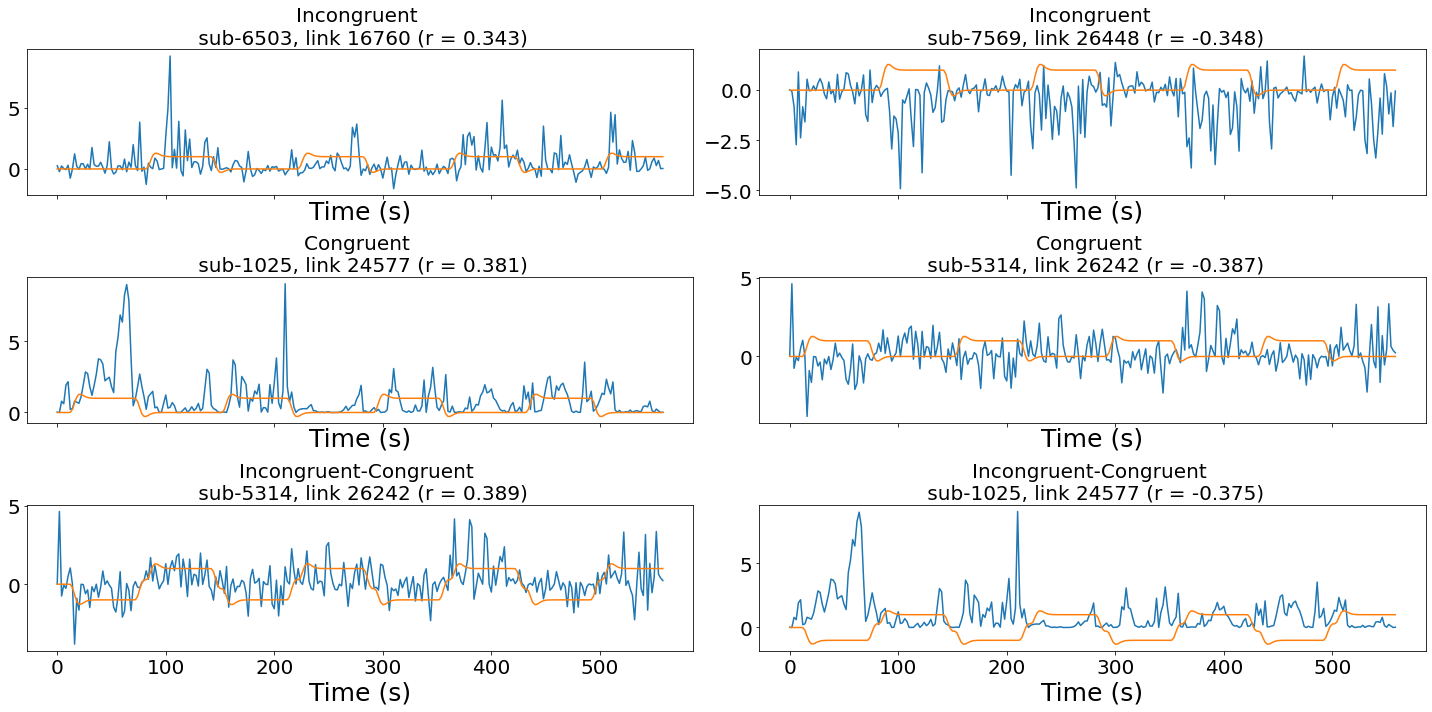

In [4]:
run_case(task_id = "stroop", output_dir = "../plots/task-stroop")

259it [03:54,  1.10it/s]


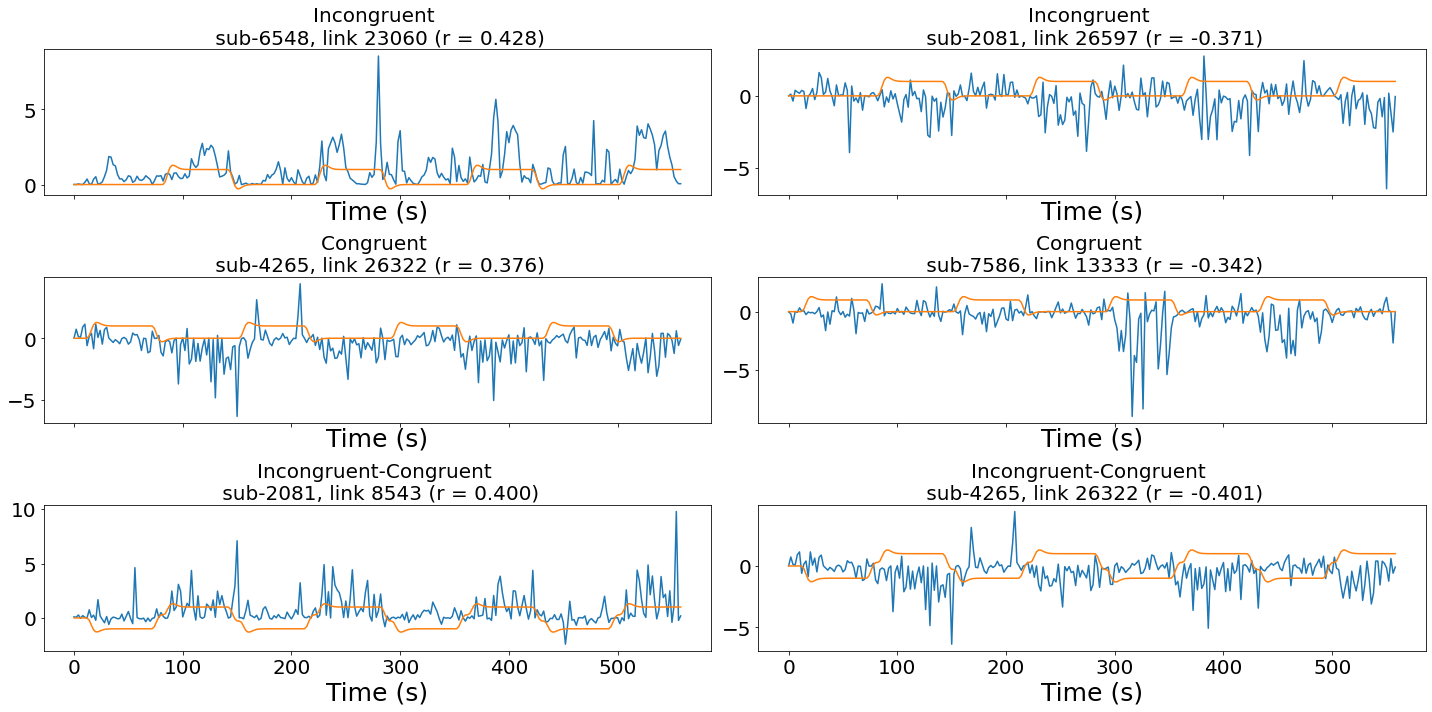

In [5]:
run_case(task_id = "msit", output_dir = "../plots/task-msit")